# Fieldlevel Take-home Project

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
df_activity = pd.read_csv('activity_data.csv')
df_email = pd.read_csv('email_data.csv')

<h3> 0. Quick EDA

In [3]:
df_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4559973 entries, 0 to 4559972
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   UserId             int64 
 1   DateOfActivityPST  object
 2   ActivityCount      int64 
dtypes: int64(2), object(1)
memory usage: 104.4+ MB


In [4]:
df_email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474163 entries, 0 to 474162
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   LogId                    474163 non-null  int64  
 1   EmailSentDateTimeUtc     474163 non-null  object 
 2   EmailCampaignId          474163 non-null  int64  
 3   EmailOpenedDateTimeUtc   139822 non-null  object 
 4   EmailClickedDateTimeUtc  23251 non-null   object 
 5   UserId                   474163 non-null  int64  
 6   ZipCode                  322050 non-null  float64
 7   AddressData              397932 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 28.9+ MB


<h3>1. How many rows are in the two datasets? If the log of emails represents 3% of the emails we sent over this period, how many emails did we send? (use python to print the numbers and display them nicely with commas)

In [5]:
# Number of rows in each datasets
print("Number of activity_data rows: " + str(df_activity.shape[0]))
print("Number of email_data_data rows: " + str(df_email.shape[0]))

# Number of total emails sent
print("Total emails sent: " + str(round((df_email["LogId"].unique().size / .03))))

Number of activity_data rows: 4559973
Number of email_data_data rows: 474163
Total emails sent: 15805433


<h3>2. What are the earliest and most recent dates of emails sent in this dataset in California time (Pacific Standard Time Zone)? (use python to print the date in format mm/dd/yyy hour:minute in 24 hour time)

In [7]:
# sort the EmailSentDateTimeUtc
df_email = df_email.sort_values(by="EmailSentDateTimeUtc")

# turn the feature 'EmailSentDateTimeUtc' from an object data-type to datetime data-type
df_datesTime = pd.to_datetime(df_email['EmailSentDateTimeUtc'])

# Add and change time zone to Pacific Standard Time Zone
df_datesTime = pd.to_datetime(df_datesTime, unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

# format earliest and most recent dates of emails sent to 'month/date/year hour:minute'
print("Earliest date and time of email-sent: " + df_datesTime.dt.strftime("%m/%d/%y %H:%M").iloc[0])
print("Most recent dates and time of emails sent: " + df_datesTime.dt.strftime("%m/%d/%y %H:%M").iloc[-1])

Earliest date and time of email-sent: 01/03/18 23:29
Most recent dates and time of emails sent: 04/19/21 09:45


<h3>3. Which 10 zip codes receive the most emails and how many emails do they receive?

In [8]:
# group by zipcode and count the emails sent, form a new table, sort it desc, and filter the top 10
most_emails_rec = df_email.groupby("ZipCode")["EmailSentDateTimeUtc"].count().to_frame().sort_values(by="EmailSentDateTimeUtc", ascending=False).head(10)

# append the total and rename the column
most_emails_rec.pivot_table(index='ZipCode', margins=True, margins_name='total', aggfunc=sum).rename(columns = {"EmailSentDateTimeUtc":"Number of Emails Received"})

,Number of Emails Received
ZipCode,
33801.0,310
34210.0,299
36104.0,254
38301.0,295
40769.0,234
42301.0,266
63301.0,312
67460.0,285
85225.0,229


<h3>4. Plot a single graph. Make sure the graph communicates clearly to team members not used to looking at the data (e.g. the axis make sense, labels are clear, there's a title, etc.) Plot two data sets:

    total distinct users who were sent at least 1 email by month and year.

In [9]:
# create a copy of eamil dataset
df_email_processed = df_email.copy()

# turn the feature 'EmailSentDateTimeUtc' to datetime data-type and drop the date, hour, and minute.
df_email_processed['EmailSentDateTimeUtc'] = pd.to_datetime(df_email_processed['EmailSentDateTimeUtc']).dt.strftime("%y/%m")

# group by year/month and filter out distinct users and form a new table with an index EmailSentDateTimeUtc 
# and a UserId column
num_of_email_sent = df_email_processed.groupby("EmailSentDateTimeUtc")["UserId"].nunique().to_frame()

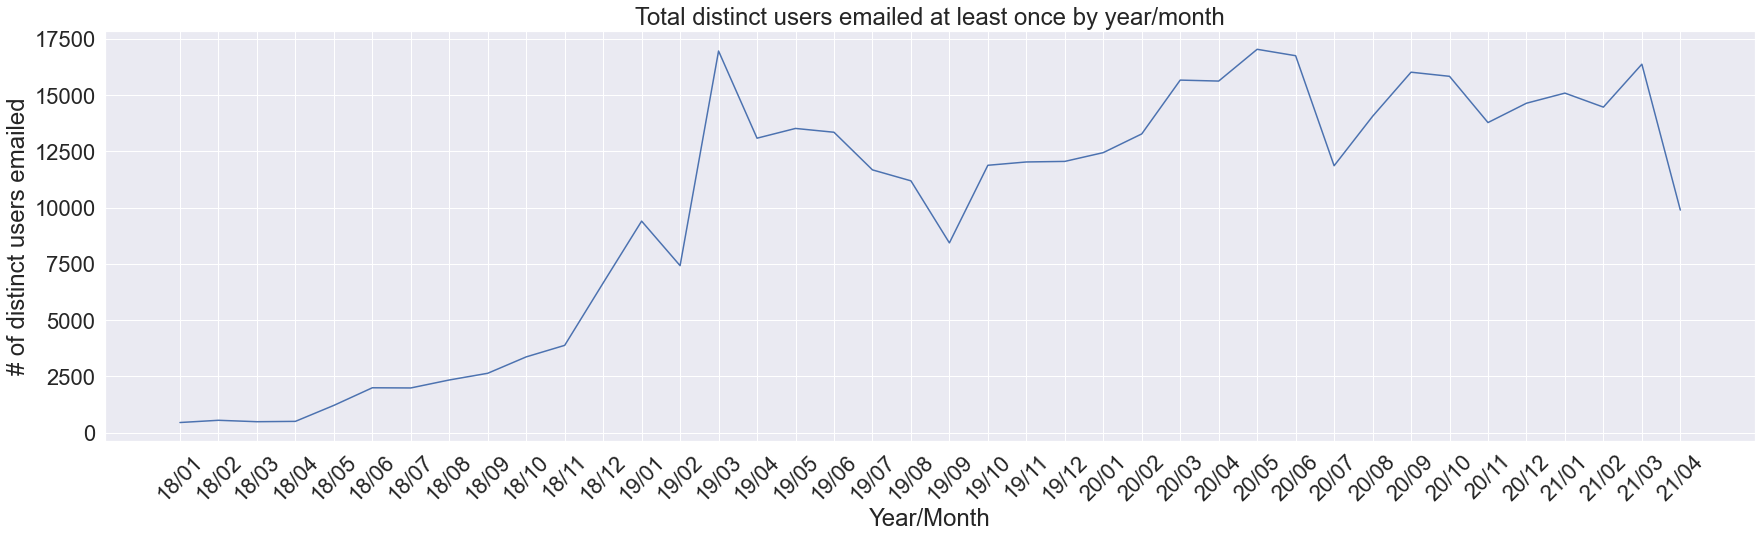

In [10]:
# set graph dimension 
plt.figure(figsize=(25,8))

# set label size
sns.set(font_scale = 2)
# plot
sns.lineplot(data=num_of_email_sent["UserId"])

# title
plt.title('Total distinct users emailed at least once by year/month')
# rotate x-axis
plt.xticks(rotation=45)

# set label name
plt.xlabel("Year/Month")
plt.ylabel("# of distinct users emailed")

plt.tight_layout()
plt.show()

    the monthly percentage of users who were sent an email and were active the same day

In [11]:
# create a copy of activity dataset
df_activity_processed = df_activity.copy()

# turn the feature 'DateOfActivityPST' to datetime data-type and drop the date, hour, and minute.
df_activity_processed['DateOfActivityPST'] = pd.to_datetime(df_activity_processed['DateOfActivityPST']).dt.strftime("%y/%m")

In [12]:
# combine 2 datasets
# since there are way more user activity instances than the email sent instance, we expect the combine dataset to be a lot bigger
# alternative way "df = df_email_processed.join(df_activity_processed.set_index('UserId'), on='UserId')""
df = pd.merge(df_email_processed, df_activity_processed, on='UserId', how='left')

In [13]:
# filter users where the activity time is same as the date the email was sent
instances_with_same_day_email = df[df['EmailSentDateTimeUtc'] == df['DateOfActivityPST']]

# count the unique users within a month for same day email
same_day_email = instances_with_same_day_email.groupby("EmailSentDateTimeUtc")["UserId"].nunique().to_frame()

# count the unique users within a month for all emails sent
email_all = df.groupby("EmailSentDateTimeUtc")["UserId"].nunique().to_frame()

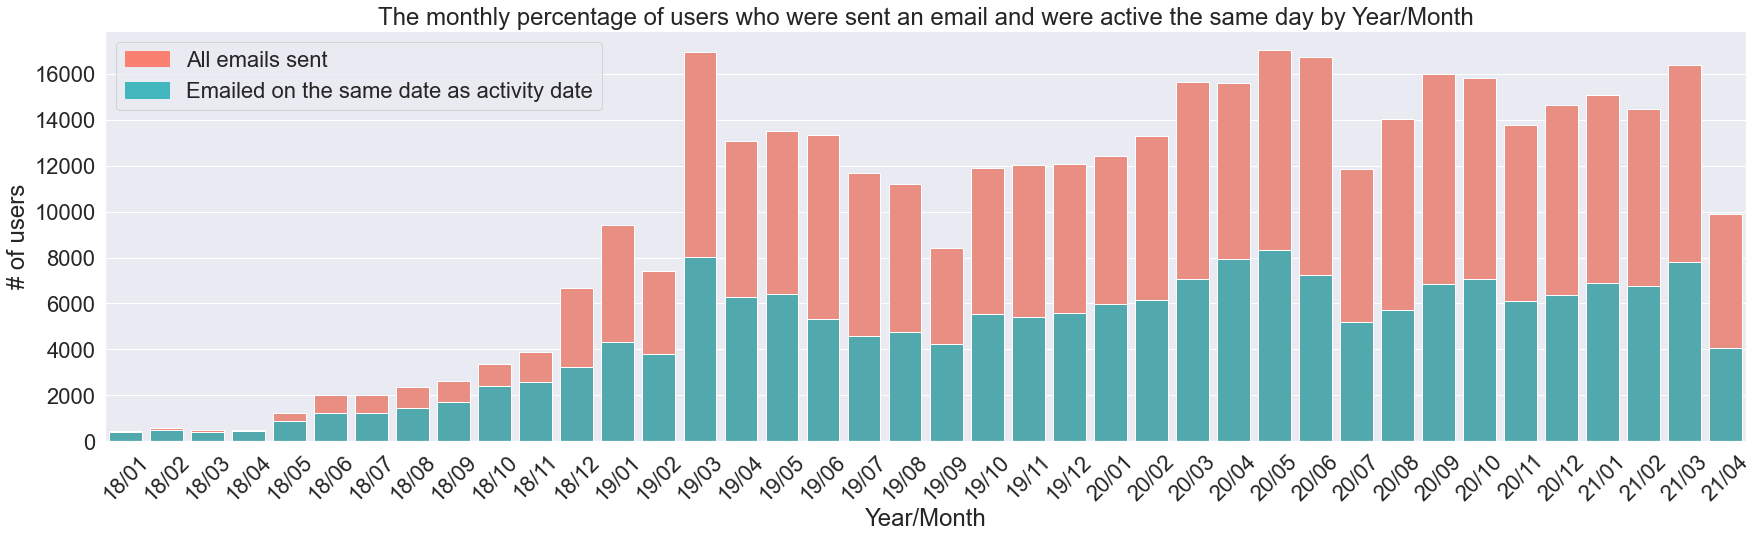

In [14]:
# set graph dimension 
plt.figure(figsize=(25,8))

# set label size
sns.set(font_scale = 2)
# plot all the emails sent
sns.barplot(x=email_all.index, y="UserId", data=email_all, color="salmon")
# plot emailed the same day where the user is active
sns.barplot(x=same_day_email.index, y="UserId", data=same_day_email, color="#42b7bd")

# title
plt.title('The monthly percentage of users who were sent an email and were active the same day by Year/Month')
# rotate x-axis
plt.xticks(rotation=45)

# lengend label
salmon_patch = mpatches.Patch(color='salmon', label='All emails sent')
blue_patch = mpatches.Patch(color='#42b7bd', label='Emailed on the same date as activity date')
plt.legend(handles=[salmon_patch, blue_patch])

# set label name
plt.xlabel("Year/Month")
plt.ylabel("# of users")

plt.tight_layout()
plt.show()

<h3>5. All the emails we send contain at least one link users can click which should send them to the FieldLevel app (where they would login and become active for that day). The team is curious if any of the links are broken. A broken link would be indicated by a record of email sent and clicked but no record of user activity on the day of the click. Estimate how many emails (by EmailCampaignId) may have broken links. If you find an EmailCampaignId that has possible broken links, estimate an upper bound for the number of users it has effected and the probability a user who gets email from us has experienced a broken link multiple times. For your answer, write a paragraph using clear language that non-technical members of the team will understand.

In [15]:
# filter out users who clicked 
user_who_clicked = df[df['EmailClickedDateTimeUtc'].notnull()]

# filter out users who clicked but no activity
clicked_but_no_act = user_who_clicked[user_who_clicked['ActivityCount'].isnull()]

# Number of emails with bad links by EmailCampaignId
emails_with_badLink = clicked_but_no_act['EmailCampaignId'].unique().size

# highest number users effected by a bad link
highest_num_ppl_effected = clicked_but_no_act.groupby("EmailCampaignId")["UserId"].nunique().max()

# the total number of user who got bad links
total_users_with_badLinks = clicked_but_no_act['UserId'].unique().size

# users who got more than 1 bad links
user_badLinks_moreThanOne = clicked_but_no_act['UserId'].value_counts().to_frame()
num_user_badLinks_moreThanOne = user_badLinks_moreThanOne[user_badLinks_moreThanOne['UserId']>1].size

# % of (user get bad email)>1 = ((user with bad email)>1) / total number of users who got bad emails
prob_moreThanOneBadEmail = round(num_user_badLinks_moreThanOne / total_users_with_badLinks, 3)*100

In [16]:
# Number of emails with bad links by EmailCampaignId
print("Number of emails with broken links (via EmailCampaignId): " + str(emails_with_badLink))

# upper bound for the number of users it has effected by the bad link
print("The highest number of users effected by a bad link: " + str(highest_num_ppl_effected)) 

# probability a user who gets email from us has experienced a broken link multiple times
print("Number of users who recived more than 1 broken link: " + str(prob_moreThanOneBadEmail) + "%") 

Number of emails with broken links (via EmailCampaignId): 20
The highest number of users effected by a bad link: 31
Number of users who recived more than 1 broken link: 7.3%


Out of the 2 datasets, there are a total of 107 emails with 20 unique eamil campaign Ids that users had clicked with no activities logged. The Id, that effected highest quantity of unique users, effect 31 different users. And the probability of a user who recived multiple bad links is around 7.3%.

<h3>6. The team's product manager is thinking we may be sending too much email. Is there a campaign that we should consider no longer sending? (e.g. its performance has never been good). When looking at performance of the emails does time matter or do they perform consistently over time?

In [17]:
# let's target emails that never got open due to bad title or its call-of-action (COA) button never got clicked

# filter out all the emails that never got opened or its COA never got clicked on
not_openedOrClicked_email = df_email_processed[(df_email_processed['EmailOpenedDateTimeUtc'].isnull()) | (df_email_processed['EmailClickedDateTimeUtc'].isnull())]

# lets set our threshold of bad email as eamil campaign that sends out 3168 bad emails or more (top 12 worse preforming emailId)
# and save a list of bad eamil campaign into "bad_emailId_list"
bad_emailId_list = not_openedOrClicked_email['EmailCampaignId'].value_counts().head(12).to_frame()


# create an object "bad_emailId" to hold all the instances of bad emails
bad_emailId = {}
i=0
while i < 12:
    bad_emailId[i] =  not_openedOrClicked_email[not_openedOrClicked_email['EmailCampaignId'] == bad_emailId_list.index[i]]
    #group by date and count the unique users it effected each month
    bad_emailId[i] = bad_emailId[i].groupby("EmailSentDateTimeUtc")["UserId"].nunique().to_frame().copy()
    i+=1

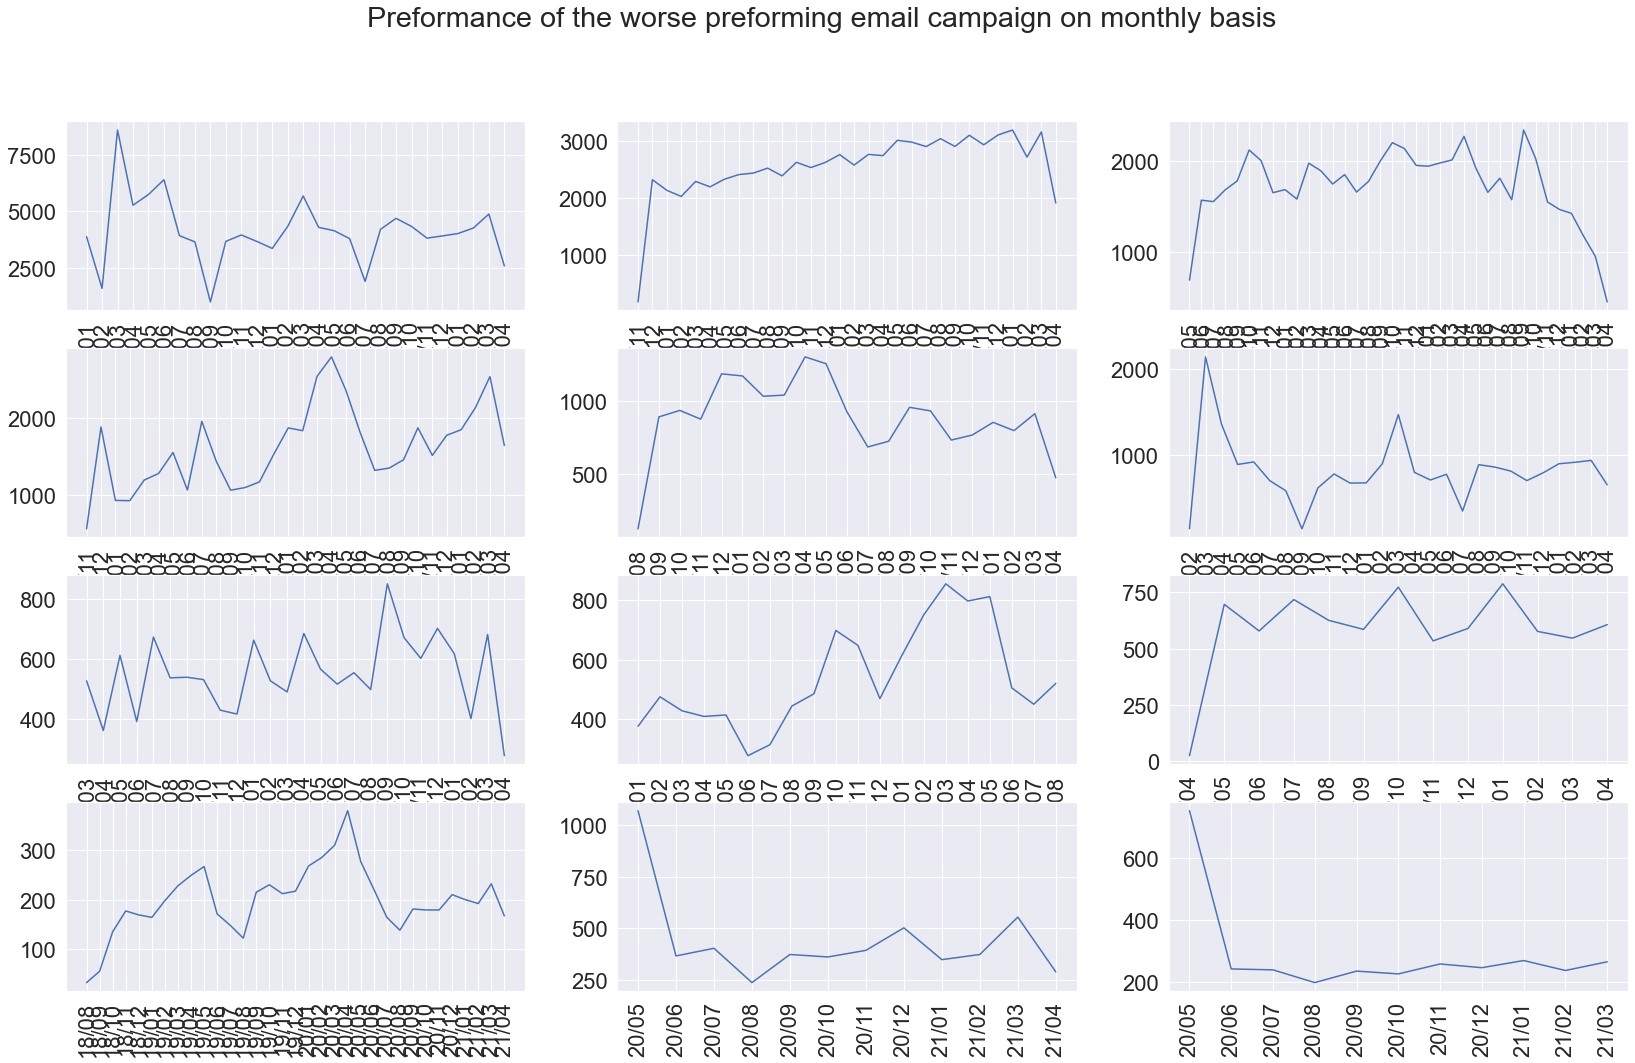

In [18]:
fig, axes = plt.subplots(4, 3, figsize=(28,16))
fig.suptitle('Preformance of the worse preforming email campaign on monthly basis')

# rotate x-axis for every column
for ax in fig.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)

# plot
row = 0
col = 0
i = 0
while row < 4:
    while col < 3:
        sns.lineplot(ax=axes[row, col], data=bad_emailId[i]["UserId"])
        i += 1
        col += 1
    col = 0
    row += 1

The graph shows that the top 10 worst performing email campaigns seem to be consistently underperforming with the top 11th and 12th improving dramatically from may to june of 2020. Even among the top 10 worst performing email campaigns, the number 1 worst performing email (#82833411612) under perform on a way bigger scale compared to its counterparts: with 8000 bad emails in a month as opposed to 3000, the second worst. Therefore, there is mounting evidence against the continuation of email campaign id #82833411612.

In [455]:
bad_emailId_list

,EmailCampaignId
82833411612,119896
479810600058,78301
653571247008,77258
192312213095,52368
461658501013,23782
480484577588,22244
653559880232,14556
866429603262,13443
567459485975,7731
642285457495,6903


<h3>7. Almost every email that we send has a 'call to action' button that sends users to the FieldLevel app. The team wants to experiment with the way the 'call to action' buttons are designed. They have a new design that they think will encourage more people to click on the button. In order to test the new design the team will select a group of users to experiment on. They plan to separate the users who get email into two 'experimental groups':

* an 'experiment' group whose emails will have the new button design after the experiment launch data
    * a 'control' group whose email will have the current button design after the experiment launch data
    The team wants to have about 50% of the users in the experiment assigned to the 'experiment' group and 50% assigned to the control group. They are using the following rules to assign users to the groups:
    * Users with a userid between 20000000 and 1000000000000 will be included in the experiment
    * Users with a userid greater than 498689408027 will be the 'experiment' group
    * Users with a userid less than or equal to 498689408027 will be the 'control' group
    * Once the experiment launches the team wants to track changes to the probability of an email getting clicked. In preparation for the experiment launch, plot a graph comparing the probability a user clicks on an email for each of the two experimental groups aggregated on a daily basis. In a paragraph, describe whether you think this is a good experimental design. In particular, what is good about the strategy for assigning users to experimental groups and what concerns do you have.

Answer: I don't think this is a good experiment design because the control and the experiment groups are not selected by random but rather in bulk: control<498689408027<experiment. Within 20000000-1000000000000, I would use "df.sample(n = 498689408027)" for the control group, and "df.sample(n = 501290591973)" for experiment group to randomly select subjects.

    plot a graph comparing the probability a user clicks on an email for each of the two experimental groups aggregated on a daily basis

In [19]:
# grab users for a/b test
df_abTest = df_email[(df_email['UserId']>20000000) & (df_email['UserId']<1000000000000)]
# experiment group
df_exp_group = df_abTest[df_abTest['UserId']>498689408027]
# control group
df_control_group = df_abTest[df_abTest['UserId']<=498689408027]

In [23]:
# looking for the click rate among both groups

# total emails sent in control group
contol_email_sum = df_control_group['EmailSentDateTimeUtc'].value_counts().sum()
# total emails sent in exp group
exp_email_sum = df_exp_group['EmailSentDateTimeUtc'].value_counts().sum()

# total emails clicked in control group
contol_emailClicked_sum = control_email_clicked['EmailSentDateTimeUtc'].value_counts().sum()
# total emails clicked in exp group
exp_emailClicked_sum = exp_email_clicked['EmailSentDateTimeUtc'].value_counts().sum()

# % of user click on control group email
per_control = (contol_emailClicked_sum/contol_email_sum)*100
# % of user click on exp group email
per_exp = (exp_emailClicked_sum/exp_email_sum)*100

In [24]:
# prepare new table for plot

# truncate the time
df_control_group['EmailSentDateTimeUtc'] = pd.to_datetime(df_control_group['EmailSentDateTimeUtc']).dt.date
df_exp_group['EmailSentDateTimeUtc'] = pd.to_datetime(df_exp_group['EmailSentDateTimeUtc']).dt.date

# total email sent for both groups
control_total_email_sent = df_control_group['EmailSentDateTimeUtc'].value_counts().to_frame()
exp_total_email_sent = df_exp_group['EmailSentDateTimeUtc'].value_counts().to_frame()

# filter out instances where the email COA got clicked for both group
control_email_clicked = df_control_group[df_control_group['EmailClickedDateTimeUtc'].notnull()]
exp_email_clicked = df_exp_group[df_exp_group['EmailClickedDateTimeUtc'].notnull()]

# group the days where emails got licked for both groups
control_email_clicked = control_email_clicked['EmailSentDateTimeUtc'].value_counts().to_frame()
exp_email_clicked = exp_email_clicked['EmailSentDateTimeUtc'].value_counts().to_frame()

<ipython-input-24-72307aa58ed7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_control_group['EmailSentDateTimeUtc'] = pd.to_datetime(df_control_group['EmailSentDateTimeUtc']).dt.date
<ipython-input-24-72307aa58ed7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp_group['EmailSentDateTimeUtc'] = pd.to_datetime(df_exp_group['EmailSentDateTimeUtc']).dt.date


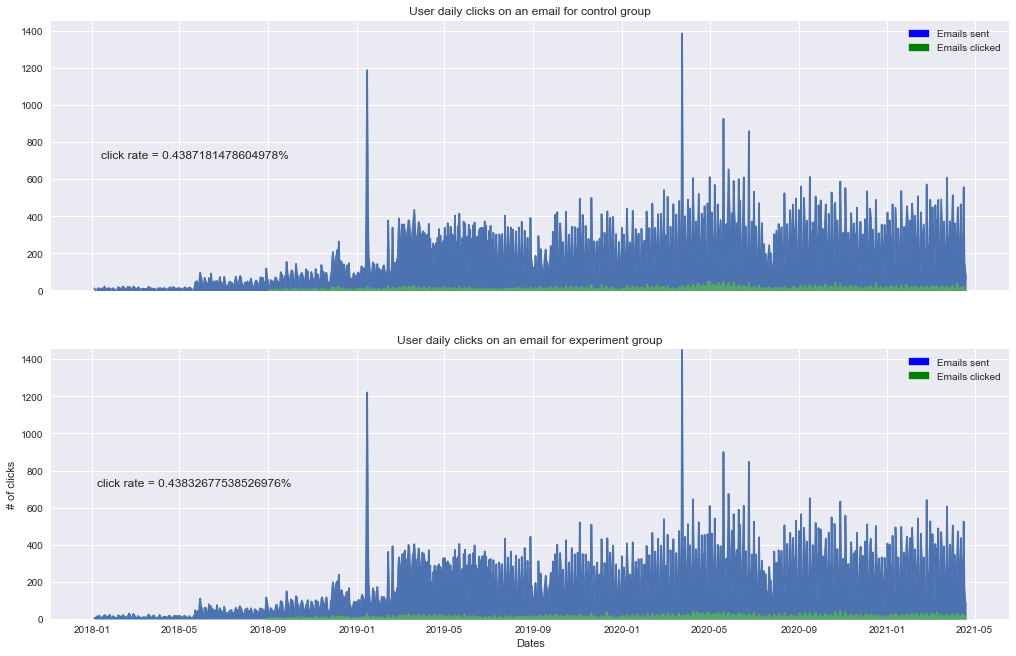

In [25]:
# set graph dimension 
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharey=True, sharex=True)


# set label size
sns.set(font_scale = 3)


# plot for control group
plt.style.use('seaborn')
control_total_email_sent["EmailSentDateTimeUtc"].plot(kind='area', stacked=True, ax = axes[0])
control_email_clicked["EmailSentDateTimeUtc"].plot(kind='area', stacked=True, ax = axes[0])
# title
axes[0].set_title('User daily clicks on an email for control group')
# click rate
axes[0].text(0.15, 0.5, 'click rate = ' + str(per_control) + '%', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes, fontsize = 12)
# labels
blue_patch = mpatches.Patch(color='blue', label='Emails sent')
green_patch = mpatches.Patch(color='green', label='Emails clicked')
axes[0].legend(handles=[blue_patch, green_patch])


# plot for exp group
plt.style.use('seaborn')
exp_total_email_sent["EmailSentDateTimeUtc"].plot(kind='area', stacked=True, ax = axes[1])
exp_email_clicked["EmailSentDateTimeUtc"].plot(kind='area', stacked=True, ax = axes[1])
# title
axes[1].set_title('User daily clicks on an email for experiment group')
# click rate
axes[1].text(0.15, 0.5, 'click rate = ' + str(per_exp) + '%', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, fontsize = 12)
# labels
axes[1].legend(handles=[blue_patch, green_patch])

# set label name
plt.xlabel("Dates")
plt.ylabel("# of clicks")

plt.tight_layout()
plt.show()

<h3>8. Finally, the product manager is worried emails are not having the impact we think. In particular they are concerned that unengaged users (users who have not logged into FieldLevel for 6 months) do not open or click on emails and because of this, efforts to re-engage users that focus on email will not be effective. The PM would like you to explore whether there is evidence that emails are effective with engaged users (users who log in without emails prompting them) but not effective on unengaged users. Explore the data, visualizing the relationship between emails sent and user activity both in login and activity count. Write a paragraph to support or argue against the product managers concern. Use statistical methods support your conclusion but balance that with plain language that non-technical users can understand.

In [26]:
# filter each user's last(most recent) date of activity
last_date_of_act = df_activity.groupby("UserId")["DateOfActivityPST"].max().to_frame()

# filter out users whos last date of activity is more than 6 months
unengaged_users = last_date_of_act[last_date_of_act['DateOfActivityPST'] < "2021-01-31"]

# Activities of users who were not active for the past 6 months
unengaged_users_activities = df_email[df_email['UserId'].isin(unengaged_users.index)]

In [30]:
# finding the open and click rate for unengaged users
reEngaged_users_viaEmailOpen_rate = round((unengaged_users_activities['EmailOpenedDateTimeUtc'].value_counts()[1] / unengaged_users_activities['EmailOpenedDateTimeUtc'].value_counts()[0])*100, 2)
reEngaged_users_viaEmailclick_rate = round((unengaged_users_activities['EmailClickedDateTimeUtc'].value_counts()[1] / unengaged_users_activities['EmailClickedDateTimeUtc'].value_counts()[0])*100, 2)

In [32]:
# turning email-open-date-time-utc feature into a binary feature

# convert all the activity date older than 6 months to 'NaN'
unengaged_users_activities.loc[unengaged_users_activities['EmailOpenedDateTimeUtc']<"2021-01-31", 'EmailOpenedDateTimeUtc'] = 'NaN'
unengaged_users_activities.loc[unengaged_users_activities['EmailClickedDateTimeUtc']<"2021-01-31", 'EmailClickedDateTimeUtc'] = 'NaN'

# convert all the activity date within the past 6 months as 1
unengaged_users_activities.loc[unengaged_users_activities['EmailOpenedDateTimeUtc']>"2021-01-31", 'EmailOpenedDateTimeUtc'] = 1
unengaged_users_activities.loc[unengaged_users_activities['EmailClickedDateTimeUtc']>"2021-01-31", 'EmailClickedDateTimeUtc'] = 1

# convert all the null value to 0
unengaged_users_activities.loc[unengaged_users_activities['EmailOpenedDateTimeUtc'].isnull(), 'EmailOpenedDateTimeUtc'] = 0
unengaged_users_activities.loc[unengaged_users_activities['EmailClickedDateTimeUtc'].isnull(), 'EmailClickedDateTimeUtc'] = 0

TypeError: '<' not supported between instances of 'int' and 'str'

Text(0.75, 0.05, 'Click Rate = 2.53%')

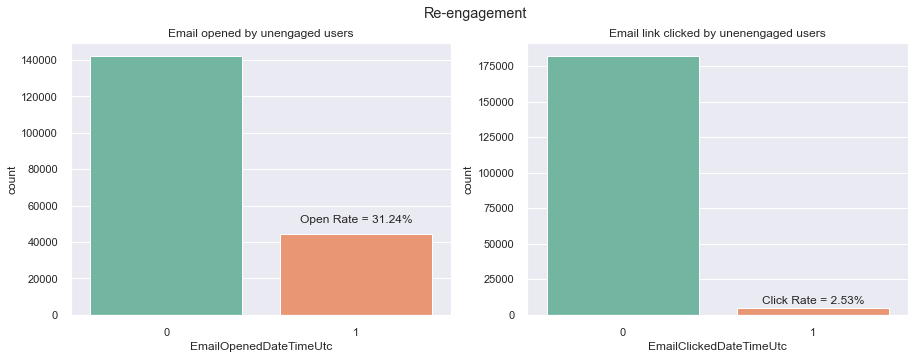

In [31]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))


sns.set(font_scale = 1)

# title
fig.suptitle('Re-engagement')

# re-engagement via email open
axes[0].set_title('Email opened by unengaged users')
# sns.countplot(x="EmailOpenedDateTimeUtc", data=unengaged_users_activities, palette = "Set2", ax=axes[0])
sns.countplot(x="EmailOpenedDateTimeUtc", data=unengaged_users_activities, palette = "Set2", ax=axes[0])
axes[0].text(0.75, 0.35, 'Open Rate = ' + str(reEngaged_users_viaEmailOpen_rate) + '%', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes, fontsize = 12)



# re-engagement via email link clicked
axes[1].set_title('Email link clicked by unenengaged users')
sns.countplot(x="EmailClickedDateTimeUtc", data=unengaged_users_activities, palette = "Set2", ax=axes[1])
axes[1].text(0.75, 0.05, 'Click Rate = ' + str(reEngaged_users_viaEmailclick_rate) + '%', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, fontsize = 12)


Depending on the quantity and types of impact we expect emails to have, the product manager's concern can be found or unfounded. If we expect email open rate among unengaged users to be 30% or lower, then the email campaign can be adequate or over-achieving. If we expect anything higher or much higher, then the email campaign is failing to re-engage users. On a different perspective, if we expect the types of impact emails should make is merely opening the email, then there is enough evidence to believe the product manager's concern is over-sensitive. But if we measure the success of email campaigns by the email-link click rate, then we should pay attention to the product manager's concern.